# Parse the Newsroom HTML

Now that we've collected all of the HTML we needed from each of the company's newsrooms, we can begin to parse the HTML to gather all of the links we need and filter out the links that don't lead to press releases.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import os

import warnings
warnings.filterwarnings('ignore')

## Get a list of all the HTML files

In [3]:
files = os.listdir('../data/html/')
html_files = [f for f in files if 'html' in f]
html_files

['exxon_mobil_html.csv',
 'walmart_html.csv',
 'amazon_html.csv',
 'cvs_health_html.csv',
 'apple_html.csv']

### Get all the links from each block of html in each of the files 

Because I want to make sure I get all of the links, I want to make sure to look through every tag available in the HTML collected in the web scraping process. First, in the code below, I iterate through each file and then through each row in the file to get the HTML from the webpage. For each block of HTML, I iterated through all of the tags and looked for any `href` attributes. If `href` is present, I create a new dictionary and start adding in key information, such as the company name, which page the link comes from, the tag it was found under and then finally the link itself. This is all added to a list of dictionaries that, once all the iterations for each files is complete, gets saved into its own file in the `links` folders. 

*Note: In order to use the `year` column to identify the label further down the line for Amazon, it is unique in that it has one additional column that the others don't.*

In [4]:
# iterate through all the files in the folder
for file in tqdm(html_files):

    # create a new file name for later
    new_file_name = file.replace('html.csv', 'links.csv')
    link_files = os.listdir('../data/links/')
    
    # create a dataframe from the csv file
    df = pd.read_csv(f'../data/html/{file}')

    # start a list that information can be appended to
    hrefs = []

    for row in range(len(df)):

        # get html from each row of the dataframe
        html = df.loc[row, 'html']

        # use BeautifulSoup to read in the html
        soup = BeautifulSoup(html, 'lxml')

        # get a list of all the tags on that page
        tags = set([tag.name for tag in soup.find_all()])

        # iterate through all of the possible tags to get
        # all of the links, regardless of how it is tagged
        for tag in tags:

            # iterate through all of the elements with that tag
            for element in soup.find_all(tag):
                # open a dictionary to append to the hrefs list
                href = {}
                # only append if the element has a link
                if 'href' in element.attrs:
                    href['company'] = df.loc[row, 'company']
                    href['newsroom_page'] = row
                    href['tag'] = tag
                    href['link'] = element.attrs['href']
                    
                    # because we already know amazon's years because of how its
                    # newsroom is structured, we can use this to our advantage
                    # later in the data cleaning process
                    
                    if 'amazon' in file:
                        href['year'] = df.loc[row, 'page_num']
                        
                    hrefs.append(href)

    links = pd.DataFrame(hrefs).drop_duplicates(subset=['link']).dropna()
    links.to_csv(f'../data/links/{new_file_name}', index=False)

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


## Editing `links` files

In [5]:
link_files = [f for f in os.listdir('../data/links/') if 'csv' in f]
link_files

['apple_links.csv',
 'walmart_links.csv',
 'cvs_health_links.csv',
 'amazon_links.csv',
 'exxon_mobil_links.csv']

To demonstrate the change in file lengths, I'm collecting the lengths of the files before and after the data cleaning process. The code below collects the lengths prior to data cleaning and puts them into a DataFrame called `priors`.

In [6]:
prior_lengths = []

for file in link_files:
    info = {}
    df = pd.read_csv(f'../data/links/{file}')
    info['company'] = df['company'][0]
    info['prior_length'] = len(df)
    prior_lengths.append(info)
    
priors = pd.DataFrame(prior_lengths)

Due to the volume of unnecessary/irrelevant links obtained by just grabbing all of the HTML from the webpage, the below filters out anything that *isn't* a link to a press release using a loop and saving the filtered DataFrame back to the links file. 

Because most of the companies in our list structure their press release links to include the year, I can use this to filter out not just the non-press release links, but also the press releases that are outside of the time frame I'm examining (i.e., earlier than 2019). 

However, CVS does not use this structure, and so we'll have to filter those out once we have the press releases themselves and can get the dates. Additionally, for Amazon, I don't have to be concerned with any press release links outside of the time frame I'm examining due to how the data was collected (i.e., by *year* instead of by *page*).

In [7]:
pr_links_dict = {
    'Apple': {
        'link': '/newsroom/20(21|20|19)',
        'base': 'https://www.apple.com'
    },
    'Walmart': {
        'link': 'https://corporate.walmart.com/newsroom/20(21|20|19)',
        'base': ''
    },
    'CVS Health': {
        'link': '/(newsroom|news-and-insights)/press-releases/',
        'base': 'https://www.cvshealth.com'
    },
    'Amazon': {
        'link': '/news-releases/news-release-details/',
        'base': 'https://press.aboutamazon.com'
    },
    'Exxon Mobil': {
        'link': '/News/Newsroom/News-releases/20(21|20|19)',
        'base': 'https://corporate.exxonmobil.com'
    }
}

In [8]:
# filter the links based on the filter string and add the base url
for file in link_files:
    df = pd.read_csv(f'../data/links/{file}').dropna()
    company = df.company[0]
    filter_string = pr_links_dict[company]['link']
    df = df[df['link'].str.contains(filter_string)]
    df['base'] = pr_links_dict[company]['base']
    df.to_csv(f'../data/links/{file}', index=False)


Here I do the same thing as I did when I measured the number of links above, just this time I'm doing so after the data cleaning process has taken place. The code below collects the lengths post-data cleaning and puts them into a DataFrame called `posts`.

In [9]:
post_lengths = []

for file in link_files:
    info = {}
    df = pd.read_csv(f'../data/links/{file}')
    info['company'] = df['company'][0]
    info['post_length'] = len(df)
    post_lengths.append(info)

posts = pd.DataFrame(post_lengths)

In order to better compare the two DataFrames, I've merged them together below in the `lengths` DataFrame. 

In [10]:
lengths = priors.merge(posts,on='company')

lengths

,company,prior_length,post_length
0,Apple,5242,263
1,Walmart,1105,437
2,CVS Health,997,767
3,Amazon,548,449
4,Exxon Mobil,255,143


In [30]:
(lengths.prior_length.sum()-lengths.post_length.sum())/lengths.prior_length.sum()

0.7472689333496992

In [32]:
lengths.post_length.sum()

2059

As seen in the graph below, cleaning up the links removed unnecessary links from all of the files, the most notable of which is Apple, that lost roughly 95% of the links we gathered.

Prior to cleaning up the files, there were 8,147 links in total. After cleaning up the files, there are 2,059 links in total, which means that close to three-quarters (74.7%) of the links we collected from the HTML have nothing to do with press releases and we are now left with a more targeted group of links from which we can start collecting press releases.

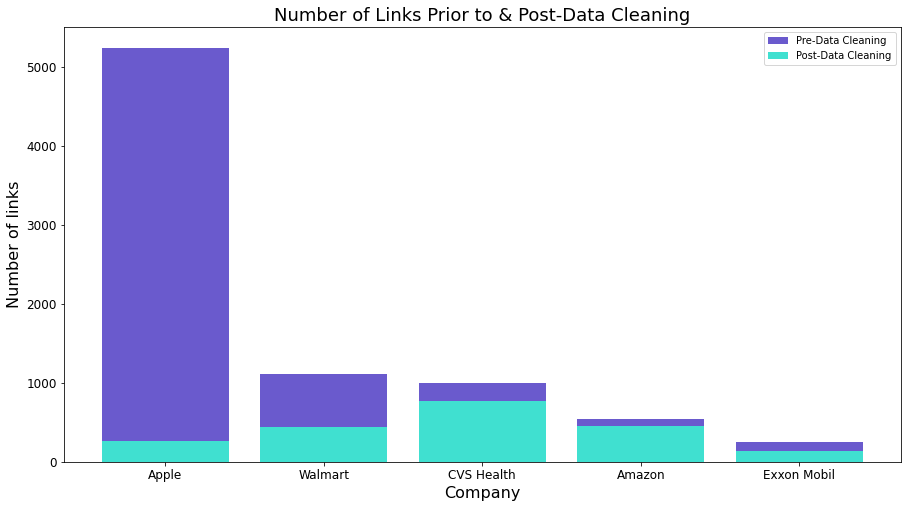

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(lengths.company,
       lengths.prior_length,
       label='Pre-Data Cleaning',
       color='slateblue')
ax.bar(lengths.company,
       lengths.post_length,
       label='Post-Data Cleaning',
       color='turquoise')
ax.set_title('Number of Links Prior to & Post-Data Cleaning',
             fontdict={'fontsize': 18})
ax.set_xlabel('Company', fontdict={'fontsize': 16})
ax.set_ylabel('Number of links', fontdict={'fontsize': 16})
ax.set_xticklabels(lengths.company, fontdict={'fontsize': 12})
ax.set_yticklabels(range(0, 6000, 1000), fontdict={'fontsize': 12})
ax.legend();

fig.savefig('../assets/links_pre_post_cleaning.png')